In [1]:
from pennylane import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt

In [2]:
gamma = 1
L = 2
n = 2
2*gamma/(L**2)*(4**n)

8.0

In [2]:
import bs_unitaries1 as bs

In [3]:
linit=np.array([2.42989539e+02,-1.21958638e+00,  1.16977027e+00,  3.94347014e-01,  4.18138649e-01,
 -3.63177974e-01,  3.66936856e-01,  1.14825348e+00,  9.44881553e-01,
  4.76602659e-01 ,-5.08380239e-01,  6.44845993e-01,  9.24789209e-01,
 -1.06035373e+00, -4.79018020e-01,  6.27273684e-01 , 1.72509477e+00,
  2.29120908e-01, -2.82348606e-01, -5.69182891e-02,  1.61783041e+00,
  2.85935176e-01, -1.80553841e+00,  1.43291946e+00, -1.43186197e+00,
  2.34415263e-01,  1.28504825e+00, -1.61842472e+00,  1.62841186e+00,
  2.82137203e-01, -2.28625036e-01, -1.72633340e+00 ])

In [4]:
#Test circuit for outputting ansatz state given a set of params
def checkwave_circuit(params):
    """
    Args: params (nd.array): An array of optimizable parameters
    
    length of params should be 31
    """
    bs.SymU(params,wires=[0,1,2,3,4,5])
    
    
qml.enable_tape()
dev = qml.device('default.qubit', wires=6)

@qml.qnode(dev)
def checkwave(params):
    checkwave_circuit(params)
    return qml.state()

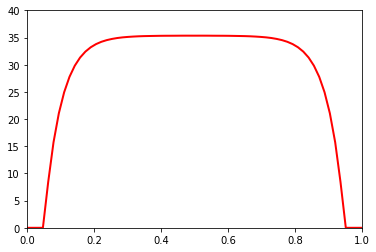

In [5]:
fig = plt.figure()
y=np.linspace(0,1,2**6)
ax = plt.axes(xlim=(0, 1), ylim=(0, 40))
line, = ax.plot(y,  linit[0]*np.real(checkwave(linit[1:])), 'r', lw=2)

In [6]:
n=6
dev = qml.device('default.qubit', wires=2*n-1)

@qml.qnode(dev)
def QNPU(l, l_old, O):
    wires=[]
    for i in range(2*n-1):
        wires.append(i)

    #Append first Hadamard Gate
    qml.Hadamard(wires=0)
    
    #Evaluates the expectation <ψ(lold)|1|ψ(lnew)>
    if O==0:
        bs.cSymU(params=l_old[1:], wires=[*wires[:n+1]])
        qml.inv(bs.cSymU(params=l[1:], wires=[*wires[:n+1]]))
    
    #Evaluates the expectation <ψ(lold)|A|ψ(lnew)>
    elif O==1:
        bs.cSymU(params=l_old[1:], wires=[wires[0], *wires[n-1:2*n-1]])
        bs.cAdder(wires=wires)
        qml.inv(bs.cSymU(params=l[1:], wires=[wires[0], *wires[n-1:2*n-1]]))
    
    #Evaluates the expectation <ψ(lold)|At|ψ(lnew)>
    elif O==2:
        bs.cSymU(params=l_old[1:], wires=[wires[0], *wires[n-1:2*n-1]])
        bs.cAdder(wires=wires,inverse=True)
        qml.inv(bs.cSymU(params=l[1:], wires=[wires[0], *wires[n-1:2*n-1]]))
    
    #Evaluates the expectation <ψ(lnew)|A|ψ(lnew)>
    elif O==3:
        bs.SymU(params=l[1:], wires=[*wires[n-1:2*n-1]])
        bs.cAdder(wires=wires)
    
    #Evaluates the expectation <ψ(lnew)|A^2|ψ(lnew)>
    elif O==4:
        bs.SymU(params=l[1:], wires=[*wires[n-1:2*n-1]])
        bs.cAdder(wires=wires)
        bs.cAdder(wires=wires)
        
    #Append second Hadamard Gate
    qml.Hadamard(wires=0)
    return qml.expval(qml.PauliZ(wires=0))

In [7]:
#Black Scholes Parameters
S_max=135 #maximum stock price
K=50 #strike price
r=0.3 #risk-free interest rate
vol=0.2 #volatility
L = 2*np.log(S_max) #length of interval [-log S_max, log S_max] or [0, 2*log S_max]

In [8]:
def C(lnew,lold,t=0.01):
    n=6
    exp=[]
    for i in range(5):
        exp.append(QNPU(lnew, lold, i))
    
    alpha=1-r*t
    beta=(0.5*(vol**2)-r)*t
    gamma=0.5*(vol**2)*t
    
    term1=r-(vol**2)*(4**n/L**2)*(exp[3]-1)
    term2=r**2+((vol**2/2-r)**2+r*vol**2)*(4**n/L**2)*(2-2*exp[3])+(vol**4/4)*(4**(2*n)/L**4)*(2*exp[4]-8*exp[3]+6)
    
    term3=(alpha-2*gamma*4**n/L**2)*exp[0] + (gamma*4**n/L**2 - beta*2**(n-1)/L)*exp[1] +(gamma*4**n/L**2+beta*2**(n-1)/L)*exp[2]
    
    return lold[0]**2 + (lnew[0]**2)*(1-2*t*term1+(t**2)*term2)-2*lold[0]*lnew[0]*term3

In [11]:
def time_evolve(params):
    
    opt1 = qml.AdamOptimizer(stepsize=0.001)

    params1 = params

    costs = 0
    best_params = None
    best_cost = 1e10
    
    def cost_function(l):
        return C(l,params)

    for i in range(1500):
        params1, costs = opt1.step_and_cost(lambda w: cost_function(w), params1)
        #print(costs)
        if i % 100 == 0:
            print(str(i) +"th cost is " + str(costs))
            print(str(i) +"th cost is " + str(params1))
        if best_cost > costs:
            best_cost = costs
            best_params = params1
    
  
    
    return best_params

    #print(best_cost)
    #print(best_params)

In [12]:
def time_evolve_n(n):
    sol = []
    l1 = time_evolve(linit)
    sol.append(l1)
    print("Initial condition is finished")
    for i in range(n):
        l1 = time_evolve(l1)
        sol.append(l1)
        print(str(i) + "th step is finished")
        
    return sol

In [13]:
solution = time_evolve_n(50)

0th cost is 0.6853258608753094
0th cost is [ 2.42990539e+02 -1.22058638e+00  1.17077027e+00  3.93347014e-01
  4.17138649e-01 -3.62177974e-01  3.65936856e-01  1.14925348e+00
  9.45881553e-01  4.77602659e-01 -5.09380239e-01  6.43845993e-01
  9.25789209e-01 -1.05935373e+00 -4.80018020e-01  6.26273684e-01
  1.72409477e+00  2.28120908e-01 -2.83348606e-01 -5.79182890e-02
  1.61883041e+00  2.86935176e-01 -1.80453841e+00  1.43191946e+00
 -1.43286197e+00  2.33415263e-01  1.28404825e+00 -1.61942472e+00
  1.62941186e+00  2.83137203e-01 -2.27625036e-01 -1.72533340e+00]
100th cost is 0.5900957748963265
100th cost is [ 2.43052528e+02 -1.21973005e+00  1.16994096e+00  3.94181206e-01
  4.17366113e-01 -3.62453719e-01  3.66209416e-01  1.14902955e+00
  9.44857964e-01  4.76755258e-01 -5.08504844e-01  6.44851400e-01
  9.24783435e-01 -1.06023088e+00 -4.79168581e-01  6.27296199e-01
  1.72500025e+00  2.28989115e-01 -2.82229244e-01 -5.68560042e-02
  1.61777695e+00  2.85812444e-01 -1.80540062e+00  1.43300531e+00

Initial condition is finished
0th cost is 0.6906406046036864
0th cost is [ 2.43734249e+02 -1.22073999e+00  1.17091187e+00  3.93137185e-01
  4.16313843e-01 -3.61410449e-01  3.65178623e-01  1.15004345e+00
  9.45061934e-01  4.78509342e-01 -5.10304494e-01  6.44634729e-01
  9.25022361e-01 -1.05840115e+00 -4.80964288e-01  6.27109057e-01
  1.71836863e+00  2.22225522e-01 -2.77452311e-01 -5.22280497e-02
  1.61317481e+00  2.81041847e-01 -1.79858746e+00  1.43760028e+00
 -1.43859081e+00  2.27513397e-01  1.28996020e+00 -1.61375393e+00
  1.62373603e+00  2.77227593e-01 -2.21690508e-01 -1.71963440e+00]
100th cost is 0.594277446725755
100th cost is [ 2.43796244e+02 -1.21988472e+00  1.17008549e+00  3.93968572e-01
  4.16503771e-01 -3.61648062e-01  3.65413615e-01  1.14985667e+00
  9.44021153e-01  4.77681354e-01 -5.09447247e-01  6.45656155e-01
  9.24000794e-01 -1.05925893e+00 -4.80135318e-01  6.28149102e-01
  1.71919439e+00  2.22973541e-01 -2.76207311e-01 -5.10899639e-02
  1.61204596e+00  2.79793602e-01 -1

0th step is finished
0th cost is 0.6961705663852626
0th cost is [ 2.44480315e+02 -1.22087983e+00  1.17109166e+00  3.92961067e-01
  4.15438181e-01 -3.60594767e-01  3.64366480e-01  1.15090227e+00
  9.43508243e-01  4.80232675e-01 -5.11960192e-01  6.46188000e-01
  9.23441253e-01 -1.05667531e+00 -4.82688286e-01  6.28710566e-01
  1.70875831e+00  2.12185554e-01 -2.67407388e-01 -4.26750101e-02
  1.60361655e+00  2.70965469e-01 -1.78849782e+00  1.44716563e+00
 -1.44816345e+00  2.17470148e-01  1.29998397e+00 -1.60425474e+00
  1.61420882e+00  2.67171403e-01 -2.11617768e-01 -1.71007678e+00]
100th cost is 0.5983406372688478
100th cost is [ 2.44542315e+02 -1.22002557e+00  1.17026898e+00  3.93788753e-01
  4.15569013e-01 -3.60773766e-01  3.64542213e-01  1.15077428e+00
  9.42445272e-01  4.79430288e-01 -5.11128154e-01  6.47231865e-01
  9.22397649e-01 -1.05750684e+00 -4.81884855e-01  6.29773119e-01
  1.70952344e+00  2.12846562e-01 -2.66068209e-01 -4.14830563e-02
  1.60243388e+00  2.69622405e-01 -1.7891511

1th step is finished
0th cost is 0.7019172532891389
0th cost is [ 2.45228755e+02 -1.22100849e+00  1.17127161e+00  3.92779852e-01
  4.14538384e-01 -3.59692414e-01  3.63523282e-01  1.15183141e+00
  9.41237366e-01  4.82639866e-01 -5.14332191e-01  6.48440066e-01
  9.21225096e-01 -1.05431170e+00 -4.85079907e-01  6.30949102e-01
  1.69781822e+00  2.00632310e-01 -2.55843941e-01 -3.17650346e-02
  1.59272756e+00  2.59405815e-01 -1.77690892e+00  1.45810446e+00
 -1.45913267e+00  2.05904407e-01  1.31156878e+00 -1.59337848e+00
  1.60326369e+00  2.55588206e-01 -2.00013455e-01 -1.69909848e+00]
100th cost is 0.6025451753666857
100th cost is [ 2.45290761e+02 -1.22015511e+00  1.17045349e+00  3.93603033e-01
  4.14602396e-01 -3.59804257e-01  3.63632803e-01  1.15177020e+00
  9.40154038e-01  4.81861977e-01 -5.13525282e-01  6.49505156e-01
  9.20160700e-01 -1.05511841e+00 -4.84300995e-01  6.32032063e-01
  1.69855484e+00  2.01254960e-01 -2.54457403e-01 -3.05512349e-02
  1.59152307e+00  2.58015844e-01 -1.7775236

2th step is finished
0th cost is 0.7078410796966637
0th cost is [ 2.45979585e+02 -1.22115774e+00  1.17143973e+00  3.92581377e-01
  4.13551814e-01 -3.58780130e-01  3.62603751e-01  1.15276660e+00
  9.38720835e-01  4.85323185e-01 -5.16977986e-01  6.50998273e-01
  9.18731128e-01 -1.05165563e+00 -4.87780865e-01  6.33488301e-01
  1.68829672e+00  1.90418263e-01 -2.45612071e-01 -2.22917927e-02
  1.58326512e+00  2.49153199e-01 -1.76667719e+00  1.46760008e+00
 -1.46867774e+00  1.95694994e-01  1.32178705e+00 -1.58390340e+00
  1.59378666e+00  2.45378967e-01 -1.89768308e-01 -1.68954460e+00]
100th cost is 0.607081207621377
100th cost is [ 2.46041596e+02 -1.22030514e+00  1.17062709e+00  3.93399456e-01
  4.13559913e-01 -3.58837491e-01  3.62658158e-01  1.15276105e+00
  9.37624483e-01  4.84562439e-01 -5.16189062e-01  6.52077703e-01
  9.17653345e-01 -1.05244409e+00 -4.87019368e-01  6.34584390e-01
  1.68902789e+00  1.91040848e-01 -2.44216694e-01 -2.10806944e-02
  1.58206303e+00  2.47753915e-01 -1.76729176

3th step is finished
0th cost is 0.713898472735309
0th cost is [ 2.46732817e+02 -1.22129315e+00  1.17161562e+00  3.92383668e-01
  4.12555052e-01 -3.57823249e-01  3.61660328e-01  1.15377217e+00
  9.36377490e-01  4.87860971e-01 -5.19485766e-01  6.53346443e-01
  9.16387447e-01 -1.04918306e+00 -4.90278964e-01  6.35878081e-01
  1.68135409e+00  1.84791017e-01 -2.37940256e-01 -1.53995011e-02
  1.57641904e+00  2.41492698e-01 -1.75903630e+00  1.47452749e+00
 -1.47561434e+00  1.88029493e-01  1.32943284e+00 -1.57701092e+00
  1.58691040e+00  2.37722814e-01 -1.82116095e-01 -1.68258696e+00]
100th cost is 0.6119506497925613
100th cost is [ 2.46794834e+02 -1.22044080e+00  1.17080797e+00  3.93196676e-01
  4.12522303e-01 -3.57839730e-01  3.61674414e-01  1.15380746e+00
  9.35279270e-01  4.87106926e-01 -5.18704159e-01  6.54428465e-01
  9.15306964e-01 -1.04996468e+00 -4.89523728e-01  6.36976202e-01
  1.68208088e+00  1.83549310e-01 -2.36673314e-01 -1.41918204e-02
  1.57522030e+00  2.40222339e-01 -1.75979247

4th step is finished
0th cost is 0.7200858738651732
0th cost is [ 2.47488464e+02 -1.22144548e+00  1.17180924e+00  3.92197272e-01
  4.11544358e-01 -3.56854149e-01  3.60662558e-01  1.15481986e+00
  9.34324549e-01  4.90046796e-01 -5.21682025e-01  6.55383760e-01
  9.14374552e-01 -1.04703530e+00 -4.92497293e-01  6.37911189e-01
  1.67614220e+00  1.79746452e-01 -2.32919348e-01 -1.02360690e-02
  1.57133368e+00  2.36395689e-01 -1.75406797e+00  1.48172132e+00
 -1.48079472e+00  1.82941072e-01  1.33446322e+00 -1.57183621e+00
  1.58180142e+00  2.32663673e-01 -1.77092623e-01 -1.67734749e+00]
100th cost is 0.6170332145993598
100th cost is [ 2.47550486e+02 -1.22059315e+00  1.17100705e+00  3.93005092e-01
  4.11480191e-01 -3.56839363e-01  3.60645051e-01  1.15488667e+00
  9.33224281e-01  4.89298322e-01 -5.20905360e-01  6.56466778e-01
  9.13292694e-01 -1.04781223e+00 -4.91747969e-01  6.39010683e-01
  1.67673715e+00  1.78529154e-01 -2.31672610e-01 -8.90649843e-03
  1.57001403e+00  2.35145496e-01 -1.7548572

5th step is finished
0th cost is 0.7263954412483145
0th cost is [ 2.48246539e+02 -1.22157770e+00  1.17198745e+00  3.91988758e-01
  4.10514827e-01 -3.55857584e-01  3.59642603e-01  1.15590515e+00
  9.32592180e-01  4.91939879e-01 -5.23528102e-01  6.57089635e-01
  9.12666332e-01 -1.04515276e+00 -4.94378720e-01  6.39638436e-01
  1.67207841e+00  1.76559418e-01 -2.29663349e-01 -6.27022222e-03
  1.56738999e+00  2.31129326e-01 -1.75082774e+00  1.48579294e+00
 -1.48480659e+00  1.79745694e-01  1.33768055e+00 -1.56786781e+00
  1.57781962e+00  2.29436016e-01 -1.73860561e-01 -1.67330948e+00]
100th cost is 0.6223065002268413
100th cost is [ 2.48308566e+02 -1.22072656e+00  1.17119054e+00  3.92791267e-01
  4.10425046e-01 -3.55816748e-01  3.59598265e-01  1.15599798e+00
  9.31495799e-01  4.91192405e-01 -5.22753158e-01  6.58169335e-01
  9.11587184e-01 -1.04592741e+00 -4.93630409e-01  6.40734077e-01
  1.67265503e+00  1.75426186e-01 -2.28484353e-01 -4.92740251e-03
  1.56605544e+00  2.31953600e-01 -1.7516952

6th step is finished
0th cost is 0.7328397314122412
0th cost is [ 2.49007054e+02 -1.22172854e+00  1.17216961e+00  3.91777273e-01
  4.09435477e-01 -3.54803729e-01  3.58628590e-01  1.15698594e+00
  9.31270604e-01  4.93449089e-01 -5.24991534e-01  6.58428837e-01
  9.11378845e-01 -1.04367741e+00 -4.95864536e-01  6.40977150e-01
  1.66891940e+00  1.74595982e-01 -2.27667823e-01 -3.22540598e-03
  1.56435420e+00  2.29098208e-01 -1.74887543e+00  1.48891527e+00
 -1.48792207e+00  1.77768760e-01  1.33967029e+00 -1.56482041e+00
  1.57478095e+00  2.27444612e-01 -1.71894122e-01 -1.67018643e+00]
100th cost is 0.6277283107920084
100th cost is [ 2.49069087e+02 -1.22087789e+00  1.17137781e+00  3.92574814e-01
  4.09322832e-01 -3.54739237e-01  3.58560922e-01  1.15710167e+00
  9.30179324e-01  4.92701410e-01 -5.24216712e-01  6.59503977e-01
  9.10304496e-01 -1.04445185e+00 -4.95115740e-01  6.42067763e-01
  1.66951967e+00  1.73479175e-01 -2.26496603e-01 -1.91423026e-03
  1.56305114e+00  2.29929318e-01 -1.7497594

7th step is finished
0th cost is 0.7394194432999939
0th cost is [ 2.49770020e+02 -1.22186762e+00  1.17234056e+00  3.91547463e-01
  4.08324315e-01 -3.53742456e-01  3.57578699e-01  1.15808360e+00
  9.30191442e-01  4.94676274e-01 -5.26211207e-01  6.59462681e-01
  9.10333600e-01 -1.04248945e+00 -4.97100307e-01  6.42021564e-01
  1.66655305e+00  1.73298447e-01 -2.26336941e-01 -9.75946807e-04
  1.56207904e+00  2.27726839e-01 -1.74754352e+00  1.49126760e+00
 -1.49024613e+00  1.76484163e-01  1.34101308e+00 -1.56257433e+00
  1.57251252e+00  2.26064499e-01 -1.70571658e-01 -1.66779952e+00]
100th cost is 0.6332779721706174
100th cost is [ 2.49832058e+02 -1.22101744e+00  1.17155336e+00  3.92340518e-01
  4.08190483e-01 -3.53656193e-01  3.57489296e-01  1.15822033e+00
  9.29106128e-01  4.93927451e-01 -5.25435651e-01  6.60531685e-01
  9.09265207e-01 -1.04326516e+00 -4.96350368e-01  6.43106082e-01
  1.66717808e+00  1.72199464e-01 -2.25174831e-01  3.01582995e-04
  1.56080969e+00  2.28565888e-01 -1.7484446

8th step is finished
0th cost is 0.7461414785939269
0th cost is [ 2.50535448e+02 -1.22200152e+00  1.17254614e+00  3.91344706e-01
  4.07222345e-01 -3.52637956e-01  3.56522200e-01  1.15922997e+00
  9.29392556e-01  4.95694434e-01 -5.27193846e-01  6.60310099e-01
  9.09536445e-01 -1.04151992e+00 -4.98122789e-01  6.42882261e-01
  1.66476077e+00  1.72416981e-01 -2.25396106e-01  7.09002636e-04
  1.56040824e+00  2.26795049e-01 -1.74664906e+00  1.49303711e+00
 -1.49202568e+00  1.75606982e-01  1.34196057e+00 -1.56088547e+00
  1.57083424e+00  2.25126451e-01 -1.69688425e-01 -1.66598855e+00]
100th cost is 0.6389492021553451
100th cost is [ 2.50597491e+02 -1.22115177e+00  1.17176304e+00  3.92133864e-01
  4.07068513e-01 -3.52531190e-01  3.56412306e-01  1.15938695e+00
  9.28311930e-01  4.94946532e-01 -5.26419067e-01  6.61374602e-01
  9.08472678e-01 -1.04229525e+00 -4.97374031e-01  6.43962541e-01
  1.66541368e+00  1.71336817e-01 -2.24243685e-01  1.94942344e-03
  1.55917560e+00  2.27643598e-01 -1.7475686

9th step is finished
0th cost is 0.753017737501068
0th cost is [ 2.51303359e+02 -1.22214835e+00  1.17275746e+00  3.91139596e-01
  4.06047163e-01 -3.51534293e-01  3.55426028e-01  1.16035382e+00
  9.28736794e-01  4.96531618e-01 -5.28049137e-01  6.60957355e-01
  9.08895654e-01 -1.04072228e+00 -4.98975492e-01  6.43575184e-01
  1.66336713e+00  1.71844476e-01 -2.24746825e-01  2.00461459e-03
  1.55916056e+00  2.26159052e-01 -1.74606253e+00  1.49439274e+00
 -1.49339945e+00  1.75031700e-01  1.34261889e+00 -1.55961488e+00
  1.56960158e+00  2.24490821e-01 -1.69104046e-01 -1.66459549e+00]
100th cost is 0.6447449934930773
100th cost is [ 2.51365407e+02 -1.22129910e+00  1.17197775e+00  3.91925546e-01
  4.05873563e-01 -3.51407901e-01  3.55296555e-01  1.16053037e+00
  9.27663243e-01  4.95781798e-01 -5.27272708e-01  6.62014073e-01
  9.07839662e-01 -1.04149982e+00 -4.98225020e-01  6.44648242e-01
  1.66405067e+00  1.70784576e-01 -2.23605356e-01  3.20543325e-03
  1.55796787e+00  2.27018155e-01 -1.74700187

10th step is finished
0th cost is 0.7600510255142581
0th cost is [ 2.52073763e+02 -1.22229048e+00  1.17297493e+00  3.90932535e-01
  4.04866325e-01 -3.50418889e-01  3.54296183e-01  1.16151586e+00
  9.28225877e-01  4.97258488e-01 -5.28737582e-01  6.61478541e-01
  9.08368763e-01 -1.04002520e+00 -4.99709130e-01  6.44134245e-01
  1.66227568e+00  1.71484413e-01 -2.24301764e-01  2.92877671e-03
  1.55824002e+00  2.25703021e-01 -1.74568944e+00  1.49542866e+00
 -1.49446216e+00  1.74653689e-01  1.34508294e+00 -1.55868464e+00
  1.56866481e+00  2.22056432e-01 -1.68714405e-01 -1.66356611e+00]
100th cost is 0.650676952500362
100th cost is [ 2.52135817e+02 -1.22144084e+00  1.17219825e+00  3.91715667e-01
  4.04673237e-01 -3.50273746e-01  3.54148534e-01  1.16171266e+00
  9.27162009e-01  4.96506969e-01 -5.27961111e-01  6.62527484e-01
  9.07321795e-01 -1.04080466e+00 -4.98957051e-01  6.45198232e-01
  1.66296277e+00  1.70433882e-01 -2.23156245e-01  4.10630545e-03
  1.55707340e+00  2.26528392e-01 -1.7466239

11th step is finished
0th cost is 0.7672489050892182
0th cost is [ 2.52846058e+02 -1.22243765e+00  1.17319373e+00  3.90718588e-01
  4.03696641e-01 -3.49281198e-01  3.53137101e-01  1.16272758e+00
  9.27780847e-01  4.97874218e-01 -5.29333938e-01  6.61904773e-01
  9.07964752e-01 -1.03940994e+00 -5.00351658e-01  6.44579972e-01
  1.66147713e+00  1.71261940e-01 -2.23971955e-01  3.56570926e-03
  1.55763418e+00  2.25337644e-01 -1.74543059e+00  1.49618648e+00
 -1.49523532e+00  1.76429709e-01  1.34539048e+00 -1.55800011e+00
  1.56801245e+00  2.21738336e-01 -1.68440452e-01 -1.66276515e+00]
100th cost is 0.6567071012250381
100th cost is [ 2.52908117e+02 -1.22158947e+00  1.17241897e+00  3.91499892e-01
  4.03484469e-01 -3.49116980e-01  3.52969733e-01  1.16294367e+00
  9.26721363e-01  4.97124800e-01 -5.28558049e-01  6.62948462e-01
  9.06922722e-01 -1.04018642e+00 -4.99602120e-01  6.45639467e-01
  1.66219333e+00  1.70246660e-01 -2.22852130e-01  4.70115100e-03
  1.55651119e+00  2.26214039e-01 -1.746404

12th step is finished
0th cost is 0.7746275217505172
0th cost is [ 2.53621487e+02 -1.22259551e+00  1.17341782e+00  3.90500564e-01
  4.02446618e-01 -3.48138360e-01  3.51940281e-01  1.16390869e+00
  9.27450389e-01  4.98424955e-01 -5.29841012e-01  6.62269447e-01
  9.07631641e-01 -1.03887000e+00 -5.00934020e-01  6.44960480e-01
  1.66086373e+00  1.71223543e-01 -2.21762313e-01  4.04071459e-03
  1.55713618e+00  2.25147448e-01 -1.74530752e+00  1.49678848e+00
 -1.49582817e+00  1.76298219e-01  1.34556977e+00 -1.55755034e+00
  1.56758865e+00  2.21523599e-01 -1.68315430e-01 -1.66212937e+00]
100th cost is 0.6629433465423062
100th cost is [ 2.53683551e+02 -1.22174807e+00  1.17264366e+00  3.91280773e-01
  4.02215533e-01 -3.47954763e-01  3.51753241e-01  1.16414352e+00
  9.26397795e-01  4.97678478e-01 -5.29068510e-01  6.63305261e-01
  9.06598419e-01 -1.03964675e+00 -5.00187857e-01  6.46016181e-01
  1.66167109e+00  1.69959185e-01 -2.22371118e-01  5.00252570e-03
  1.55614434e+00  2.25756572e-01 -1.746036

13th step is finished
0th cost is 0.7821909937192686
0th cost is [ 2.54399073e+02 -1.22276830e+00  1.17364474e+00  3.90276898e-01
  4.01178118e-01 -3.46943549e-01  3.50755240e-01  1.16512470e+00
  9.27148105e-01  4.98913765e-01 -5.30325104e-01  6.62546711e-01
  9.07359318e-01 -1.03839134e+00 -5.01437322e-01  6.45272044e-01
  1.66057331e+00  1.71045511e-01 -2.21431303e-01  4.16344461e-03
  1.55706938e+00  2.24818706e-01 -1.74509771e+00  1.49701443e+00
 -1.49609582e+00  1.76065406e-01  1.34586800e+00 -1.55744225e+00
  1.56750888e+00  2.21204420e-01 -1.68084012e-01 -1.66190235e+00]
100th cost is 0.6693519147520419
100th cost is [ 2.54461143e+02 -1.22192179e+00  1.17287288e+00  3.91054894e-01
  4.00927024e-01 -3.46739754e-01  3.50548121e-01  1.16537906e+00
  9.26102240e-01  4.98166831e-01 -5.29549903e-01  6.63573644e-01
  9.06334527e-01 -1.03916760e+00 -5.00690943e-01  6.46319557e-01
  1.66148385e+00  1.69802464e-01 -2.22059153e-01  5.08229898e-03
  1.55616935e+00  2.25436218e-01 -1.745846

14th step is finished
0th cost is 0.7899431656260276
0th cost is [ 2.55178753e+02 -1.22294100e+00  1.17386095e+00  3.90032772e-01
  3.99931741e-01 -3.45708001e-01  3.49573857e-01  1.16642096e+00
  9.26900385e-01  4.99353040e-01 -5.30761545e-01  6.62761999e-01
  9.07112075e-01 -1.03796434e+00 -5.01911183e-01  6.45526142e-01
  1.66046038e+00  1.70874551e-01 -2.21144290e-01  4.08568598e-03
  1.55714298e+00  2.24552508e-01 -1.74492306e+00  1.49708789e+00
 -1.49618121e+00  1.75906018e-01  1.34616984e+00 -1.55751728e+00
  1.56756565e+00  2.20926480e-01 -1.69928279e-01 -1.66178197e+00]
100th cost is 0.6756441794132115
100th cost is [ 2.55240828e+02 -1.22209576e+00  1.17309204e+00  3.90807410e-01
  3.99659031e-01 -3.45483529e-01  3.49346263e-01  1.16669542e+00
  9.25860806e-01  4.98605659e-01 -5.29985710e-01  6.63782300e-01
  9.06093755e-01 -1.03874023e+00 -5.01164894e-01  6.46566178e-01
  1.66135659e+00  1.69741887e-01 -2.21881665e-01  5.01256978e-03
  1.55623105e+00  2.25279029e-01 -1.745776

15th step is finished
0th cost is 0.7978923406481044
0th cost is [ 2.55961822e+02 -1.22307570e+00  1.17408894e+00  3.89791102e-01
  3.98660659e-01 -3.44464918e-01  3.48339768e-01  1.16773142e+00
  9.26731764e-01  4.99780235e-01 -5.31147451e-01  6.62977875e-01
  9.06928094e-01 -1.03758320e+00 -5.02348443e-01  6.45761388e-01
  1.66038565e+00  1.70865632e-01 -2.21007611e-01  4.01537152e-03
  1.55727202e+00  2.24431368e-01 -1.74690443e+00  1.49715740e+00
 -1.49627166e+00  1.75877223e-01  1.34632300e+00 -1.55758497e+00
  1.56767594e+00  2.20768327e-01 -1.69937262e-01 -1.66167234e+00]
100th cost is 0.6822485296288505
100th cost is [ 2.56023902e+02 -1.22223178e+00  1.17332304e+00  3.90562660e-01
  3.98366814e-01 -3.44218080e-01  3.48090485e-01  1.16802787e+00
  9.25704117e-01  4.99035215e-01 -5.30371144e-01  6.63990629e-01
  9.05917303e-01 -1.03835470e+00 -5.01604938e-01  6.46798612e-01
  1.66119318e+00  1.70073928e-01 -2.22081016e-01  5.07450334e-03
  1.55627909e+00  2.25500291e-01 -1.746106

16th step is finished
0th cost is 0.8060709576238878
0th cost is [ 2.56747486e+02 -1.22326373e+00  1.17432700e+00  3.89549464e-01
  3.97357213e-01 -3.43204888e-01  3.47075770e-01  1.16906233e+00
  9.26586062e-01  5.00148221e-01 -5.31531968e-01  6.63139407e-01
  9.06770599e-01 -1.03723749e+00 -5.02763568e-01  6.45953033e-01
  1.66011319e+00  1.71202469e-01 -2.21158641e-01  4.09009053e-03
  1.55721336e+00  2.24592525e-01 -1.74716772e+00  1.49742314e+00
 -1.49652875e+00  1.76200057e-01  1.34612150e+00 -1.55749135e+00
  1.56758845e+00  2.20925384e-01 -1.70251599e-01 -1.66138085e+00]
100th cost is 0.6898303794441745
100th cost is [ 2.56809572e+02 -1.22242148e+00  1.17356581e+00  3.90316485e-01
  3.97040848e-01 -3.42935373e-01  3.46803689e-01  1.16938142e+00
  9.25568964e-01  4.99403647e-01 -5.30760624e-01  6.64144866e-01
  9.05767237e-01 -1.03801209e+00 -5.02021641e-01  6.46985681e-01
  1.66097542e+00  1.70463318e-01 -2.22270698e-01  5.17209499e-03
  1.55628991e+00  2.25700737e-01 -1.746418

17th step is finished
0th cost is 0.8144654734351207
0th cost is [ 2.57535741e+02 -1.22342622e+00  1.17458681e+00  3.89318886e-01
  3.96014424e-01 -3.41914990e-01  3.45783187e-01  1.17039892e+00
  9.26459365e-01  5.00543854e-01 -5.31878453e-01  6.63252271e-01
  9.06631240e-01 -1.03690763e+00 -5.03107784e-01  6.46109950e-01
  1.65991072e+00  1.71571584e-01 -2.21348440e-01  4.09554290e-03
  1.55721170e+00  2.24782410e-01 -1.74751398e+00  1.49762495e+00
 -1.49672316e+00  1.76558893e-01  1.34589704e+00 -1.55750113e+00
  1.56758101e+00  2.21141940e-01 -1.70616871e-01 -1.66115516e+00]
100th cost is 0.6959864805976395
100th cost is [ 2.57597832e+02 -1.22258606e+00  1.17383137e+00  3.90080035e-01
  3.95674131e-01 -3.41621513e-01  3.45487046e-01  1.17074189e+00
  9.25444755e-01  4.99800331e-01 -5.31107005e-01  6.64250490e-01
  9.05634768e-01 -1.03768129e+00 -5.02366244e-01  6.47130670e-01
  1.66082707e+00  1.70884177e-01 -2.22488153e-01  5.06775676e-03
  1.55635207e+00  2.25922183e-01 -1.746812

18th step is finished
0th cost is 0.8230760931328405
0th cost is [ 2.58324592e+02 -1.22357126e+00  1.17483670e+00  3.89067532e-01
  3.94650736e-01 -3.40608007e-01  3.44447377e-01  1.17175967e+00
  9.26342788e-01  5.00888265e-01 -5.32190063e-01  6.63352214e-01
  9.06532523e-01 -1.03658042e+00 -5.03460169e-01  6.46228262e-01
  1.65974511e+00  1.71936983e-01 -2.21579094e-01  4.01611482e-03
  1.55726851e+00  2.25003845e-01 -1.74789426e+00  1.49774448e+00
 -1.49689198e+00  1.76976045e-01  1.34564491e+00 -1.55757362e+00
  1.56762809e+00  2.21384926e-01 -1.71070124e-01 -1.66099983e+00]
100th cost is 0.7033762542414479
100th cost is [ 2.58386688e+02 -1.22273340e+00  1.17408857e+00  3.89821591e-01
  3.94285322e-01 -3.40289282e-01  3.44125756e-01  1.17212826e+00
  9.25333394e-01  5.00145377e-01 -5.31418253e-01  6.64343588e-01
  9.05542797e-01 -1.03735549e+00 -5.02719506e-01  6.47241076e-01
  1.66069547e+00  1.71295668e-01 -2.22803856e-01  4.88512948e-03
  1.55645827e+00  2.26178840e-01 -1.747241

19th step is finished
0th cost is 0.831965318415314
0th cost is [ 2.59118106e+02 -1.22376271e+00  1.17510992e+00  3.88827645e-01
  3.93252915e-01 -3.39277469e-01  3.43088026e-01  1.17314709e+00
  9.26233374e-01  5.01197931e-01 -5.32513427e-01  6.63414675e-01
  9.06456427e-01 -1.03628119e+00 -5.03799048e-01  6.46322010e-01
  1.65959032e+00  1.72435971e-01 -2.21880813e-01  3.89209188e-03
  1.55736395e+00  2.25322549e-01 -1.74837476e+00  1.49785758e+00
 -1.49704171e+00  1.77439654e-01  1.34537014e+00 -1.55765367e+00
  1.56768293e+00  2.21674249e-01 -1.71532206e-01 -1.66084797e+00]
100th cost is 0.710196476225974
100th cost is [ 2.59180208e+02 -1.22292782e+00  1.17437031e+00  3.89573614e-01
  3.92860515e-01 -3.38931510e-01  3.42739578e-01  1.17354229e+00
  9.25229321e-01  5.00453859e-01 -5.31739323e-01  6.64398582e-01
  9.05473816e-01 -1.03705600e+00 -5.03057619e-01  6.47327875e-01
  1.66054900e+00  1.71867507e-01 -2.23159339e-01  4.68378514e-03
  1.55658318e+00  2.26542109e-01 -1.74779413

20th step is finished
0th cost is 0.8411011548305396
0th cost is [ 2.59914274e+02 -1.22390130e+00  1.17538324e+00  3.88575462e-01
  3.91824796e-01 -3.37882518e-01  3.41740041e-01  1.17456267e+00
  9.26148607e-01  5.01520927e-01 -5.32817875e-01  6.63467578e-01
  9.06386587e-01 -1.03601240e+00 -5.04119142e-01  6.46377069e-01
  1.65941737e+00  1.72997663e-01 -2.22187796e-01  3.79119179e-03
  1.55745539e+00  2.25696347e-01 -1.74891005e+00  1.49798468e+00
 -1.49715578e+00  1.77977646e-01  1.34502624e+00 -1.55777533e+00
  1.56779204e+00  2.22051020e-01 -1.72074620e-01 -1.66070633e+00]
100th cost is 0.7177690198004711
100th cost is [ 2.59976382e+02 -1.22306973e+00  1.17465297e+00  3.89312410e-01
  3.91404118e-01 -3.37507757e-01  3.41363092e-01  1.17498634e+00
  9.25149638e-01  5.00776206e-01 -5.32043418e-01  6.64446105e-01
  9.05409569e-01 -1.03678701e+00 -5.03376819e-01  6.47376797e-01
  1.66038332e+00  1.72483301e-01 -2.23430520e-01  4.54767970e-03
  1.55670867e+00  2.26995079e-01 -1.748381

21th step is finished
0th cost is 0.8504963908926584
0th cost is [ 2.60710595e+02 -1.22403622e+00  1.17571087e+00  3.88365378e-01
  3.90362076e-01 -3.36531507e-01  3.40299257e-01  1.17600697e+00
  9.26096571e-01  5.01814796e-01 -5.33104726e-01  6.63536183e-01
  9.06365496e-01 -1.03574634e+00 -5.04440855e-01  6.46428375e-01
  1.65929652e+00  1.73594159e-01 -2.22595187e-01  3.63242733e-03
  1.55761661e+00  2.26062225e-01 -1.74949958e+00  1.49809455e+00
 -1.49725784e+00  1.78554204e-01  1.34464618e+00 -1.55791107e+00
  1.56790594e+00  2.22400713e-01 -1.72648110e-01 -1.66057504e+00]
100th cost is 0.7260217188450042
100th cost is [ 2.60772708e+02 -1.22320807e+00  1.17499102e+00  3.89093089e-01
  3.89910702e-01 -3.36126885e-01  3.39891879e-01  1.17646031e+00
  9.25104061e-01  5.01068827e-01 -5.32329209e-01  6.64510980e-01
  9.05393666e-01 -1.03651948e+00 -5.03697509e-01  6.47422891e-01
  1.66029447e+00  1.73110629e-01 -2.23819229e-01  4.34253511e-03
  1.55691877e+00  2.27388913e-01 -1.748996

22th step is finished
0th cost is 0.8601957953360397
0th cost is [ 2.61512123e+02 -1.22416186e+00  1.17599066e+00  3.88094210e-01
  3.88862226e-01 -3.35096673e-01  3.38871320e-01  1.17746016e+00
  9.26058939e-01  5.02111234e-01 -5.33389023e-01  6.63594056e-01
  9.06373555e-01 -1.03550488e+00 -5.04749951e-01  6.46469657e-01
  1.65916222e+00  1.74233439e-01 -2.22986852e-01  3.48253603e-03
  1.55779434e+00  2.26463000e-01 -1.75014313e+00  1.49819344e+00
 -1.49734885e+00  1.79182306e-01  1.34423649e+00 -1.55806722e+00
  1.56807604e+00  2.22832390e-01 -1.73265755e-01 -1.66046074e+00]
100th cost is 0.7333685313351452
100th cost is [ 2.61574242e+02 -1.22333767e+00  1.17528084e+00  3.88812454e-01
  3.88379040e-01 -3.34660091e-01  3.38432238e-01  1.17794510e+00
  9.25071894e-01  5.01363555e-01 -5.32614879e-01  6.64565111e-01
  9.05406355e-01 -1.03628038e+00 -5.04005167e-01  6.47459340e-01
  1.66017568e+00  1.73790354e-01 -2.24225183e-01  4.16407736e-03
  1.55712169e+00  2.27747897e-01 -1.749687

23th step is finished
0th cost is 0.8702120405505411
0th cost is [ 2.62316362e+02 -1.22431614e+00  1.17628717e+00  3.87825927e-01
  3.87353668e-01 -3.33619381e-01  3.37429534e-01  1.17896839e+00
  9.26000210e-01  5.02393794e-01 -5.33664955e-01  6.63593673e-01
  9.06356099e-01 -1.03526130e+00 -5.05046884e-01  6.46465231e-01
  1.65906825e+00  1.74923271e-01 -2.23405213e-01  3.29335054e-03
  1.55800138e+00  2.26912763e-01 -1.75080098e+00  1.49828465e+00
 -1.49743847e+00  1.79847165e-01  1.34382402e+00 -1.55825666e+00
  1.56825221e+00  2.23268683e-01 -1.73923066e-01 -1.66034822e+00]
100th cost is 0.7411395373637788
100th cost is [ 2.62378486e+02 -1.22349640e+00  1.17558665e+00  3.88534877e-01
  3.86837352e-01 -3.33149334e-01  3.36957355e-01  1.17948684e+00
  9.25017517e-01  5.01644572e-01 -5.32890900e-01  6.64560281e-01
  9.05392816e-01 -1.03604012e+00 -5.04300873e-01  6.47448793e-01
  1.66007871e+00  1.74514454e-01 -2.24702885e-01  3.96733905e-03
  1.55733829e+00  2.28241110e-01 -1.750386

24th step is finished
0th cost is 0.8805426668841392
0th cost is [ 2.63119301e+02 -1.22452451e+00  1.17656452e+00  3.87524527e-01
  3.85830653e-01 -3.32127074e-01  3.35929815e-01  1.18051131e+00
  9.25995041e-01  5.02698267e-01 -5.33922255e-01  6.63574451e-01
  9.06343136e-01 -1.03500857e+00 -5.05304540e-01  6.46486120e-01
  1.65897972e+00  1.75610885e-01 -2.23867478e-01  3.07001647e-03
  1.55821280e+00  2.27365582e-01 -1.75151042e+00  1.49836382e+00
 -1.49751260e+00  1.80549491e-01  1.34339276e+00 -1.55847494e+00
  1.56844762e+00  2.23716823e-01 -1.74640794e-01 -1.66022853e+00]
100th cost is 0.7494124259101227
100th cost is [ 2.63181431e+02 -1.22370953e+00  1.17587230e+00  3.88224785e-01
  3.85279593e-01 -3.31622330e-01  3.35422957e-01  1.18106449e+00
  9.25017450e-01  5.01947878e-01 -5.33144912e-01  6.64535877e-01
  9.05384263e-01 -1.03578631e+00 -5.04556399e-01  6.47466049e-01
  1.66000050e+00  1.75232803e-01 -2.25171980e-01  3.72110761e-03
  1.55757104e+00  2.28727495e-01 -1.751118

25th step is finished
0th cost is 0.8912289928412065
0th cost is [ 2.63929025e+02 -1.22468066e+00  1.17686559e+00  3.87231512e-01
  3.84253106e-01 -3.30600044e-01  3.34413887e-01  1.18207507e+00
  9.25976200e-01  5.02959373e-01 -5.34163675e-01  6.63556224e-01
  9.06357200e-01 -1.03475808e+00 -5.05601891e-01  6.46470199e-01
  1.65884247e+00  1.76383130e-01 -2.24353095e-01  2.88317338e-03
  1.55842926e+00  2.27894497e-01 -1.75227028e+00  1.49845942e+00
 -1.49763841e+00  1.81316608e-01  1.34291372e+00 -1.55866740e+00
  1.56864680e+00  2.24222385e-01 -1.75421677e-01 -1.66010752e+00]
100th cost is 0.7579359744559042
100th cost is [ 2.63991160e+02 -1.22387066e+00  1.17618074e+00  3.87924384e-01
  3.83665990e-01 -3.30059062e-01  3.33871428e-01  1.18266421e+00
  9.25002212e-01  5.02206437e-01 -5.33382958e-01  6.64513354e-01
  9.05402456e-01 -1.03553352e+00 -5.04851543e-01  6.47445891e-01
  1.65985859e+00  1.76040424e-01 -2.25640176e-01  3.52104373e-03
  1.55780615e+00  2.29227908e-01 -1.751906

26th step is finished
0th cost is 0.9022971212107223
0th cost is [ 2.64741529e+02 -1.22488963e+00  1.17716995e+00  3.86926120e-01
  3.82610048e-01 -3.29054946e-01  3.32881288e-01  1.18366421e+00
  9.26008114e-01  5.03210983e-01 -5.34409514e-01  6.63525966e-01
  9.06387280e-01 -1.03448558e+00 -5.05862173e-01  6.46485507e-01
  1.65870831e+00  1.77195848e-01 -2.24899473e-01  2.66092894e-03
  1.55866776e+00  2.28399818e-01 -1.75309491e+00  1.49856445e+00
 -1.49775094e+00  1.82108938e-01  1.34240833e+00 -1.55885564e+00
  1.56885666e+00  2.24730979e-01 -1.76208810e-01 -1.65997682e+00]
100th cost is 0.76675966772018
100th cost is [ 2.64803670e+02 -1.22408469e+00  1.17649127e+00  3.87612529e-01
  3.81985769e-01 -3.28477406e-01  3.32301720e-01  1.18429075e+00
  9.25039420e-01  5.02455659e-01 -5.33627102e-01  6.64478369e-01
  9.05436382e-01 -1.03526155e+00 -5.05109830e-01  6.47455018e-01
  1.65973203e+00  1.76834643e-01 -2.26306123e-01  3.27474037e-03
  1.55807218e+00  2.29829684e-01 -1.75274811

27th step is finished
0th cost is 0.9137417765159626
0th cost is [ 2.65556207e+02 -1.22508128e+00  1.17747749e+00  3.86608047e-01
  3.80959691e-01 -3.27456131e-01  3.31313138e-01  1.18529339e+00
  9.26029237e-01  5.03494356e-01 -5.34635203e-01  6.63492507e-01
  9.06425321e-01 -1.03423758e+00 -5.06123289e-01  6.46461312e-01
  1.65859129e+00  1.77996833e-01 -2.25428345e-01  2.41639877e-03
  1.55894300e+00  2.28894667e-01 -1.75388927e+00  1.49864649e+00
 -1.49782567e+00  1.82935456e-01  1.34190419e+00 -1.55908077e+00
  1.56913018e+00  2.25227012e-01 -1.77028547e-01 -1.65986221e+00]
100th cost is 0.7764363434107509
100th cost is [ 2.65618354e+02 -1.22428110e+00  1.17680438e+00  3.87289041e-01
  3.80296910e-01 -3.26840638e-01  3.30695512e-01  1.18595737e+00
  9.25066478e-01  5.02738135e-01 -5.33852629e-01  6.64440903e-01
  9.05478631e-01 -1.03501393e+00 -5.05368961e-01  6.47425626e-01
  1.65963197e+00  1.77667945e-01 -2.26743762e-01  2.99395955e-03
  1.55837559e+00  2.30322539e-01 -1.753450

28th step is finished
0th cost is 0.9255911010259297
0th cost is [ 2.66374347e+02 -1.22526660e+00  1.17780201e+00  3.86289997e-01
  3.79317039e-01 -3.25831780e-01  3.29694290e-01  1.18698957e+00
  9.26063189e-01  5.03769944e-01 -5.34856587e-01  6.63462389e-01
  9.06491307e-01 -1.03398552e+00 -5.06381484e-01  6.46434221e-01
  1.65848878e+00  1.78806444e-01 -2.25941887e-01  2.17839974e-03
  1.55920920e+00  2.29403354e-01 -1.75471370e+00  1.49876058e+00
 -1.49792441e+00  1.83797841e-01  1.34135926e+00 -1.55936156e+00
  1.56938921e+00  2.25766127e-01 -1.77921480e-01 -1.65973933e+00]
100th cost is 0.7858865468588192
100th cost is [ 2.66436499e+02 -1.22447084e+00  1.17713401e+00  3.86965907e-01
  3.78615548e-01 -3.25177808e-01  3.29037904e-01  1.18769241e+00
  9.25106117e-01  5.03013465e-01 -5.34075894e-01  6.64406212e-01
  9.05550116e-01 -1.03476522e+00 -5.05627265e-01  6.47392497e-01
  1.65954128e+00  1.78537999e-01 -2.27252132e-01  2.72341934e-03
  1.55867364e+00  2.30779685e-01 -1.754433

29th step is finished
0th cost is 0.9378963531926274
0th cost is [ 2.67195344e+02 -1.22550846e+00  1.17813331e+00  3.85961160e-01
  3.77623859e-01 -3.24199973e-01  3.28016365e-01  1.18870890e+00
  9.26108733e-01  5.04031469e-01 -5.35092680e-01  6.63434860e-01
  9.06560042e-01 -1.03376549e+00 -5.06659687e-01  6.46381217e-01
  1.65839275e+00  1.79655484e-01 -2.26450837e-01  1.89545189e-03
  1.55952831e+00  2.29913682e-01 -1.75558747e+00  1.49884597e+00
 -1.49801000e+00  1.84649321e-01  1.34084012e+00 -1.55963989e+00
  1.56967206e+00  2.26302640e-01 -1.78784339e-01 -1.65962104e+00]
100th cost is 0.7947489371872507
100th cost is [ 2.67257502e+02 -1.22471672e+00  1.17747050e+00  3.86631464e-01
  3.76883431e-01 -3.23507000e-01  3.27320833e-01  1.18945153e+00
  9.25157408e-01  5.03275804e-01 -5.34312908e-01  6.64371425e-01
  9.05624802e-01 -1.03454466e+00 -5.05906432e-01  6.47333449e-01
  1.65945012e+00  1.79357452e-01 -2.27806945e-01  2.41566158e-03
  1.55902495e+00  2.31310362e-01 -1.755219

30th step is finished
0th cost is 0.9506280496425461
0th cost is [ 2.68019225e+02 -1.22567338e+00  1.17854642e+00  3.85695032e-01
  3.75880426e-01 -3.22526802e-01  3.26307769e-01  1.19044796e+00
  9.26136973e-01  5.04299230e-01 -5.35309544e-01  6.63362393e-01
  9.06638651e-01 -1.03350150e+00 -5.06901379e-01  6.46326624e-01
  1.65826468e+00  1.80545530e-01 -2.26982343e-01  1.60738145e-03
  1.55983514e+00  2.30449013e-01 -1.75649324e+00  1.49892264e+00
 -1.49810002e+00  1.85520154e-01  1.34030365e+00 -1.55993087e+00
  1.56998766e+00  2.26823390e-01 -1.79674271e-01 -1.65948775e+00]
100th cost is 0.8048150853428524
100th cost is [ 2.68081390e+02 -1.22488521e+00  1.17789028e+00  3.86359082e-01
  3.75100059e-01 -3.21794380e-01  3.25572664e-01  1.19122992e+00
  9.25192341e-01  5.03545453e-01 -5.34532661e-01  6.64291018e-01
  9.05711608e-01 -1.03428000e+00 -5.06149888e-01  6.47271727e-01
  1.65932877e+00  1.80249983e-01 -2.28259947e-01  2.10719569e-03
  1.55935436e+00  2.31776834e-01 -1.756171

31th step is finished
0th cost is 0.9638487971387804
0th cost is [ 2.68846018e+02 -1.22586940e+00  1.17888927e+00  3.85339402e-01
  3.74150821e-01 -3.20806563e-01  3.24571135e-01  1.19227184e+00
  9.26186300e-01  5.04582402e-01 -5.35533090e-01  6.63289647e-01
  9.06709116e-01 -1.03327068e+00 -5.07152187e-01  6.46255183e-01
  1.65815437e+00  1.81437398e-01 -2.27499756e-01  1.30189706e-03
  1.56018077e+00  2.30974208e-01 -1.75739431e+00  1.49902673e+00
 -1.49819574e+00  1.86408339e-01  1.33978693e+00 -1.56025320e+00
  1.57031725e+00  2.27365644e-01 -1.80598981e-01 -1.65939701e+00]
100th cost is 0.8144616804493126
100th cost is [ 2.68908189e+02 -1.22508433e+00  1.17824130e+00  3.85995099e-01
  3.73331025e-01 -3.20034573e-01  3.23796164e-01  1.19309404e+00
  9.25249835e-01  5.03831915e-01 -5.34758058e-01  6.64209692e-01
  9.05790548e-01 -1.03404671e+00 -5.06403992e-01  6.47191611e-01
  1.65922679e+00  1.81175698e-01 -2.28834851e-01  1.77534179e-03
  1.55972166e+00  2.32304846e-01 -1.757126

32th step is finished
0th cost is 0.9775859059300274
0th cost is [ 2.69675755e+02 -1.22607552e+00  1.17926041e+00  3.84991545e-01
  3.72318922e-01 -3.19021614e-01  3.22828408e-01  1.19407279e+00
  9.26225839e-01  5.04820420e-01 -5.35767441e-01  6.63206667e-01
  9.06822447e-01 -1.03300614e+00 -5.07403277e-01  6.46192120e-01
  1.65805373e+00  1.82342148e-01 -2.28027086e-01  9.76569641e-04
  1.56053172e+00  2.31485372e-01 -1.75830271e+00  1.49912139e+00
 -1.49826422e+00  1.87336076e-01  1.33927243e+00 -1.56061013e+00
  1.57068376e+00  2.27879621e-01 -1.81520341e-01 -1.65928245e+00]
100th cost is 0.8250192629056983
100th cost is [ 2.69737931e+02 -1.22529319e+00  1.17862297e+00  3.85636855e-01
  3.71458913e-01 -3.18209850e-01  3.22013677e-01  1.19493470e+00
  9.25298202e-01  5.04073287e-01 -5.34995663e-01  6.64117714e-01
  9.05913801e-01 -1.03377862e+00 -5.06658886e-01  6.47119247e-01
  1.65913484e+00  1.82089851e-01 -2.29357517e-01  1.43044929e-03
  1.56009203e+00  2.32811718e-01 -1.758037

33th step is finished
0th cost is 0.9918775783153251
0th cost is [ 2.70508464e+02 -1.22631149e+00  1.17961750e+00  3.84608187e-01
  3.70443837e-01 -3.17246619e-01  3.21004113e-01  1.19591419e+00
  9.26311292e-01  5.05055984e-01 -5.35989846e-01  6.63117968e-01
  9.06923653e-01 -1.03275532e+00 -5.07681484e-01  6.46137687e-01
  1.65797079e+00  1.83314128e-01 -2.28550790e-01  6.07388807e-04
  1.56090292e+00  2.31974920e-01 -1.75924038e+00  1.49920142e+00
 -1.49835828e+00  1.88239481e-01  1.33874397e+00 -1.56099349e+00
  1.57104537e+00  2.28381427e-01 -1.82419799e-01 -1.65917018e+00]
100th cost is 0.8359525534324348
100th cost is [ 2.70570647e+02 -1.22553155e+00  1.17899285e+00  3.85240648e-01
  3.69543752e-01 -3.16395192e-01  3.20149411e-01  1.19681584e+00
  9.25393174e-01  5.04312789e-01 -5.35221240e-01  6.64019600e-01
  9.06025247e-01 -1.03352381e+00 -5.06941756e-01  6.47055726e-01
  1.65905933e+00  1.83070741e-01 -2.29876104e-01  1.04103385e-03
  1.56048297e+00  2.33295394e-01 -1.758985

34th step is finished
0th cost is 1.0067314609477762
0th cost is [ 2.71344178e+02 -1.22652407e+00  1.17998657e+00  3.84214777e-01
  3.68548521e-01 -3.15416299e-01  3.19144386e-01  1.19780131e+00
  9.26407804e-01  5.05332147e-01 -5.36215483e-01  6.63028599e-01
  9.07033547e-01 -1.03251454e+00 -5.07926403e-01  6.46072048e-01
  1.65783752e+00  1.84301446e-01 -2.29082043e-01  2.21463304e-04
  1.56130448e+00  2.32455295e-01 -1.76020439e+00  1.49930257e+00
 -1.49843843e+00  1.89163791e-01  1.33819704e+00 -1.56137242e+00
  1.57141988e+00  2.28868572e-01 -1.83343995e-01 -1.65908153e+00]
100th cost is 0.8472593250626232
100th cost is [ 2.71406367e+02 -1.22574630e+00  1.17937703e+00  3.84832243e-01
  3.67608473e-01 -3.14525265e-01  3.18249561e-01  1.19874262e+00
  9.25498778e-01  5.04593450e-01 -5.35449975e-01  6.63920605e-01
  9.06145128e-01 -1.03327933e+00 -5.07190730e-01  6.46981419e-01
  1.65892933e+00  1.84068651e-01 -2.30398196e-01  6.33092618e-04
  1.56090600e+00  2.33765706e-01 -1.759959

35th step is finished
0th cost is 1.0222011459991336
0th cost is [ 2.72182930e+02 -1.22675445e+00  1.18037948e+00  3.83822534e-01
  3.66636485e-01 -3.13575283e-01  3.17217786e-01  1.19975611e+00
  9.26516115e-01  5.05603741e-01 -5.36436521e-01  6.62931402e-01
  9.07151025e-01 -1.03225703e+00 -5.08166219e-01  6.46001921e-01
  1.65772937e+00  1.85264425e-01 -2.29596365e-01 -2.12105934e-04
  1.56173271e+00  2.32945070e-01 -1.76114486e+00  1.49939775e+00
 -1.49851462e+00  1.90148953e-01  1.33770251e+00 -1.56175653e+00
  1.57180737e+00  2.29380230e-01 -1.84300460e-01 -1.65896004e+00]
100th cost is 0.8589788921235595
100th cost is [ 2.72245125e+02 -1.22597886e+00  1.17978688e+00  3.84423432e-01
  3.65656562e-01 -3.12644916e-01  3.16282828e-01  1.20073742e+00
  9.25615752e-01  5.04869006e-01 -5.35673906e-01  6.63813856e-01
  9.06271899e-01 -1.03301833e+00 -5.07434354e-01  6.46903247e-01
  1.65881851e+00  1.85045257e-01 -2.30901181e-01  1.75866099e-04
  1.56135743e+00  2.34243384e-01 -1.760913

36th step is finished
0th cost is 1.038284886191832
0th cost is [ 2.73022412e+02 -1.22696741e+00  1.18080982e+00  3.83442723e-01
  3.64662822e-01 -3.11639372e-01  3.15300442e-01  1.20172937e+00
  9.26606277e-01  5.05834182e-01 -5.36646559e-01  6.62824119e-01
  9.07264278e-01 -1.03199611e+00 -5.08459668e-01  6.45892224e-01
  1.65763860e+00  1.86204859e-01 -2.30080481e-01 -6.63070535e-04
  1.56217638e+00  2.33414880e-01 -1.76210463e+00  1.49946992e+00
 -1.49857444e+00  1.91070077e-01  1.33723184e+00 -1.56221846e+00
  1.57226552e+00  2.29823265e-01 -1.85271015e-01 -1.65887572e+00]
100th cost is 0.8711050949641503
100th cost is [ 2.73084613e+02 -1.22619462e+00  1.18023473e+00  3.84026500e-01
  3.63643094e-01 -3.10669034e-01  3.14325342e-01  1.20275038e+00
  9.25713913e-01  5.05102370e-01 -5.35886624e-01  6.63697856e-01
  9.06393733e-01 -1.03275404e+00 -5.07731823e-01  6.46785382e-01
  1.65872059e+00  1.86000582e-01 -2.31371636e-01 -2.99970771e-04
  1.56182652e+00  2.34699250e-01 -1.7618878

37th step is finished
0th cost is 1.0550454457697924
0th cost is [ 2.73861543e+02 -1.22722176e+00  1.18124422e+00  3.83041469e-01
  3.62646231e-01 -3.09665764e-01  3.13329477e-01  1.20373651e+00
  9.26702284e-01  5.06121482e-01 -5.36866102e-01  6.62706338e-01
  9.07397872e-01 -1.03173665e+00 -5.08694529e-01  6.45788452e-01
  1.65756761e+00  1.87148391e-01 -2.30528914e-01 -1.12891026e-03
  1.56268845e+00  2.33854701e-01 -1.76304563e+00  1.49952944e+00
 -1.49864096e+00  1.92037385e-01  1.33677049e+00 -1.56268594e+00
  1.57274469e+00  2.30272626e-01 -1.86238017e-01 -1.65878265e+00]
100th cost is 0.8836802416481078
100th cost is [ 2.73923751e+02 -1.22645254e+00  1.18068633e+00  3.83608469e-01
  3.61586358e-01 -3.08655314e-01  3.12313979e-01  1.20479733e+00
  9.25817624e-01  5.05392642e-01 -5.36108541e-01  6.63572372e-01
  9.06534584e-01 -1.03249164e+00 -5.07969215e-01  6.46673653e-01
  1.65864048e+00  1.86959754e-01 -2.31804010e-01 -7.91269188e-04
  1.56236526e+00  2.35122366e-01 -1.762844

38th step is finished
0th cost is 1.0725412373139989
0th cost is [ 2.74707616e+02 -1.22744096e+00  1.18169644e+00  3.82631115e-01
  3.60582977e-01 -3.07647752e-01  3.11324727e-01  1.20579404e+00
  9.26804656e-01  5.06383970e-01 -5.37113129e-01  6.62595289e-01
  9.07532058e-01 -1.03151422e+00 -5.08971056e-01  6.45654649e-01
  1.65747963e+00  1.88128672e-01 -2.30999371e-01 -1.60702513e-03
  1.56316402e+00  2.34306107e-01 -1.76398793e+00  1.49959007e+00
 -1.49871781e+00  1.93037092e-01  1.33632541e+00 -1.56319073e+00
  1.57325505e+00  2.30692139e-01 -1.87219775e-01 -1.65867399e+00]
100th cost is 0.89674634905532
100th cost is [ 2.74769830e+02 -1.22667640e+00  1.18115464e+00  3.83182642e-01
  3.59482606e-01 -3.06596509e-01  3.10268606e-01  1.20689494e+00
  9.25926962e-01  5.05657000e-01 -5.36357991e-01  6.63455116e-01
  9.06675867e-01 -1.03226729e+00 -5.08248028e-01  6.46532272e-01
  1.65854382e+00  1.87955662e-01 -2.32258747e-01 -1.29239049e-03
  1.56286403e+00  2.35557351e-01 -1.76380113

39th step is finished
0th cost is 1.0908413720026147
0th cost is [ 2.75558862e+02 -1.22769874e+00  1.18213059e+00  3.82173937e-01
  3.58483854e-01 -3.05594589e-01  3.09266707e-01  1.20790546e+00
  9.26921618e-01  5.06646129e-01 -5.37328408e-01  6.62438237e-01
  9.07658638e-01 -1.03124515e+00 -5.09240015e-01  6.45547998e-01
  1.65736362e+00  1.89139948e-01 -2.31466635e-01 -2.08562156e-03
  1.56365375e+00  2.34774105e-01 -1.76498335e+00  1.49968215e+00
 -1.49882778e+00  1.94074584e-01  1.33586489e+00 -1.56367197e+00
  1.57373831e+00  2.31153081e-01 -1.88246010e-01 -1.65852121e+00]
100th cost is 0.9103494355804287
100th cost is [ 2.75621082e+02 -1.22694036e+00  1.18160276e+00  3.82711470e-01
  3.57342638e-01 -3.04502061e-01  3.08169215e-01  1.20904720e+00
  9.26050289e-01  5.05920172e-01 -5.36574577e-01  6.63291803e-01
  9.06808669e-01 -1.03199603e+00 -5.08518274e-01  6.46419323e-01
  1.65842110e+00  1.88979499e-01 -2.32711725e-01 -1.79124545e-03
  1.56337426e+00  2.36011163e-01 -1.764808

40th step is finished
0th cost is 1.10996729292674
0th cost is [ 2.76413225e+02 -1.22797329e+00  1.18259595e+00  3.81718719e-01
  3.56333191e-01 -3.03514541e-01  3.07141362e-01  1.21005308e+00
  9.27043736e-01  5.06900958e-01 -5.37570482e-01  6.62351419e-01
  9.07863691e-01 -1.03100611e+00 -5.09529650e-01  6.45425093e-01
  1.65724854e+00  1.90158573e-01 -2.31887891e-01 -2.58747673e-03
  1.56421628e+00  2.35184970e-01 -1.76598917e+00  1.49975603e+00
 -1.49892656e+00  1.95067328e-01  1.33541492e+00 -1.56417917e+00
  1.57427915e+00  2.31575773e-01 -1.89247916e-01 -1.65841946e+00]
100th cost is 0.9245023422408849
100th cost is [ 2.76475452e+02 -1.22722251e+00  1.18208069e+00  3.82244108e-01
  3.55150201e-01 -3.02380025e-01  3.06001664e-01  1.21123632e+00
  9.26177627e-01  5.06175459e-01 -5.36817563e-01  6.63200274e-01
  9.07019871e-01 -1.03175567e+00 -5.08809022e-01  6.46290820e-01
  1.65830134e+00  1.90007220e-01 -2.33121345e-01 -2.30964740e-03
  1.56395407e+00  2.36410282e-01 -1.76582387

41th step is finished
0th cost is 1.1299229864089284
0th cost is [ 2.77267647e+02 -1.22823902e+00  1.18307644e+00  3.81247760e-01
  3.54151446e-01 -3.01376367e-01  3.04980221e-01  1.21226231e+00
  9.27168888e-01  5.07184070e-01 -5.37805751e-01  6.62209900e-01
  9.08026641e-01 -1.03074540e+00 -5.09787477e-01  6.45288378e-01
  1.65716041e+00  1.91144699e-01 -2.32286889e-01 -3.14055686e-03
  1.56479472e+00  2.35580243e-01 -1.76699452e+00  1.49985955e+00
 -1.49896467e+00  1.96065082e-01  1.33502426e+00 -1.56473129e+00
  1.57485366e+00  2.31975916e-01 -1.90258819e-01 -1.65830268e+00]
100th cost is 0.9392041653918568
100th cost is [ 2.77329881e+02 -1.22749724e+00  1.18257238e+00  3.81761605e-01
  3.52925694e-01 -3.00199048e-01  3.03797286e-01  1.21348821e+00
  9.26307682e-01  5.06459317e-01 -5.37054076e-01  6.63053839e-01
  9.07187692e-01 -1.03149382e+00 -5.09066959e-01  6.46148904e-01
  1.65821133e+00  1.91000189e-01 -2.33510179e-01 -2.87666383e-03
  1.56454601e+00  2.36795297e-01 -1.766836

42th step is finished
0th cost is 1.1508120025973767
0th cost is [ 2.78128718e+02 -1.22847653e+00  1.18356402e+00  3.80751066e-01
  3.51921984e-01 -2.99192078e-01  3.02777835e-01  1.21452793e+00
  9.27300020e-01  5.07455408e-01 -5.38035193e-01  6.62073856e-01
  9.08197928e-01 -1.03049156e+00 -5.10081897e-01  6.45130838e-01
  1.65704348e+00  1.92202536e-01 -2.32688487e-01 -3.71899097e-03
  1.56536058e+00  2.35997294e-01 -1.76799854e+00  1.49993854e+00
 -1.49904988e+00  1.97098080e-01  1.33463284e+00 -1.56527245e+00
  1.57543790e+00  2.32360823e-01 -1.91279262e-01 -1.65814335e+00]
100th cost is 0.9545332945708651
100th cost is [ 2.78190959e+02 -1.22774469e+00  1.18307133e+00  3.81253315e-01
  3.50652244e-01 -2.97970581e-01  3.01550620e-01  1.21579770e+00
  9.26443622e-01  5.06730881e-01 -5.37284365e-01  6.62913373e-01
  9.07363375e-01 -1.03123899e+00 -5.09361585e-01  6.45986195e-01
  1.65809249e+00  1.92065690e-01 -2.33901614e-01 -3.46796004e-03
  1.56512372e+00  2.37202765e-01 -1.767847

43th step is finished
0th cost is 1.1726835948356893
0th cost is [ 2.78992825e+02 -1.22874056e+00  1.18408716e+00  3.80256166e-01
  3.49622101e-01 -2.96924029e-01  3.00550566e-01  1.21680886e+00
  9.27472513e-01  5.07763072e-01 -5.38288544e-01  6.61921438e-01
  9.08365069e-01 -1.03024732e+00 -5.10338742e-01  6.44998390e-01
  1.65694325e+00  1.93250557e-01 -2.33057688e-01 -4.33327729e-03
  1.56597539e+00  2.36358488e-01 -1.76901747e+00  1.49998613e+00
 -1.49916455e+00  1.98136798e-01  1.33428205e+00 -1.56587497e+00
  1.57603797e+00  2.32734549e-01 -1.92256080e-01 -1.65801648e+00]
100th cost is 0.970511955791153
100th cost is [ 2.79055073e+02 -1.22801937e+00  1.18360731e+00  3.80745242e-01
  3.48306659e-01 -2.95656815e-01  2.99278126e-01  1.21812386e+00
  9.26621592e-01  5.07039462e-01 -5.37539109e-01  6.62756537e-01
  9.07534534e-01 -1.03099340e+00 -5.09618508e-01  6.45848621e-01
  1.65798779e+00  1.93122341e-01 -2.34259412e-01 -4.09692316e-03
  1.56575263e+00  2.37552485e-01 -1.7688754

44th step is finished
0th cost is 1.1956059903313871
0th cost is [ 2.79860609e+02 -1.22902740e+00  1.18460923e+00  3.79724166e-01
  3.47287463e-01 -2.94624563e-01  2.98241992e-01  1.21914335e+00
  9.27643589e-01  5.08037510e-01 -5.38566403e-01  6.61745537e-01
  9.08539885e-01 -1.02999623e+00 -5.10609777e-01  6.44867540e-01
  1.65684872e+00  1.94293932e-01 -2.33402369e-01 -4.96074630e-03
  1.56665164e+00  2.36689906e-01 -1.77007402e+00  1.50006124e+00
 -1.49926135e+00  1.99122989e-01  1.33394439e+00 -1.56648696e+00
  1.57667668e+00  2.33067905e-01 -1.93259178e-01 -1.65790577e+00]
100th cost is 0.9871799647225998
100th cost is [ 2.79922864e+02 -1.22831730e+00  1.18414497e+00  3.80197245e-01
  3.45924826e-01 -2.93310166e-01  2.96922625e-01  1.22050525e+00
  9.26798245e-01  5.07314787e-01 -5.37819114e-01  6.62575444e-01
  9.07713467e-01 -1.03074032e+00 -5.09890460e-01  6.45712535e-01
  1.65788485e+00  1.94176721e-01 -2.34589416e-01 -4.74210120e-03
  1.56644728e+00  2.37869510e-01 -1.769943

45th step is finished
0th cost is 1.2196212621347513
0th cost is [ 2.80731953e+02 -1.22930067e+00  1.18516218e+00  3.79185180e-01
  3.44869302e-01 -2.92269267e-01  2.95899045e-01  1.22150798e+00
  9.27810388e-01  5.08316914e-01 -5.38809191e-01  6.61573833e-01
  9.08726366e-01 -1.02971908e+00 -5.10901683e-01  6.44711330e-01
  1.65674637e+00  1.95343756e-01 -2.33736003e-01 -5.63796921e-03
  1.56731370e+00  2.37002176e-01 -1.77111850e+00  1.50013923e+00
 -1.49935778e+00  2.00157802e-01  1.33365051e+00 -1.56714324e+00
  1.57731989e+00  2.33405133e-01 -1.94263375e-01 -1.65777401e+00]
100th cost is 1.004563147580484
100th cost is [ 2.80794216e+02 -1.22860088e+00  1.18471742e+00  3.79638855e-01
  3.43457526e-01 -2.90906158e-01  2.94531032e-01  1.22291857e+00
  9.26970993e-01  5.07595899e-01 -5.38064373e-01  6.62398300e-01
  9.07905422e-01 -1.03046049e+00 -5.10184465e-01  6.45550730e-01
  1.65776960e+00  1.95240875e-01 -2.34905549e-01 -5.44083965e-03
  1.56713022e+00  2.38163547e-01 -1.7710021

46th step is finished
0th cost is 1.2448177010810468
0th cost is [ 2.81606835e+02 -1.22960241e+00  1.18573827e+00  3.78629684e-01
  3.42428814e-01 -2.89862549e-01  2.93501579e-01  1.22395200e+00
  9.27974418e-01  5.08582683e-01 -5.39077554e-01  6.61375038e-01
  9.08923609e-01 -1.02943997e+00 -5.11194703e-01  6.44563846e-01
  1.65664926e+00  1.96357438e-01 -2.34017038e-01 -6.34484614e-03
  1.56803449e+00  2.37261519e-01 -1.77212150e+00  1.50026163e+00
 -1.49938685e+00  2.01187151e-01  1.33335492e+00 -1.56784629e+00
  1.57800495e+00  2.33679184e-01 -1.95300373e-01 -1.65767973e+00]
100th cost is 1.0227260527317412
100th cost is [ 2.81669106e+02 -1.22891203e+00  1.18531697e+00  3.79060229e-01
  3.40966235e-01 -2.88449047e-01  2.92082737e-01  1.22541324e+00
  9.27141458e-01  5.07864549e-01 -5.38336291e-01  6.62192884e-01
  9.08109389e-01 -1.03017778e+00 -5.10481185e-01  6.45397182e-01
  1.65765589e+00  1.96271686e-01 -2.35165188e-01 -6.17140091e-03
  1.56787506e+00  2.38400929e-01 -1.772021

47th step is finished
0th cost is 1.2712767289485782
0th cost is [ 2.82485240e+02 -1.22992761e+00  1.18631729e+00  3.78036014e-01
  3.39911417e-01 -2.87414956e-01  2.91046763e-01  1.22643402e+00
  9.28139060e-01  5.08832376e-01 -5.39348539e-01  6.61170691e-01
  9.09119884e-01 -1.02915744e+00 -5.11517676e-01  6.44389856e-01
  1.65656818e+00  1.97363324e-01 -2.34242425e-01 -7.09531757e-03
  1.56880119e+00  2.37511551e-01 -1.77312568e+00  1.50031347e+00
 -1.49945231e+00  2.02186806e-01  1.33312488e+00 -1.56858788e+00
  1.57874441e+00  2.33913981e-01 -1.96324493e-01 -1.65758923e+00]
100th cost is 1.041724034526851
100th cost is [ 2.82547518e+02 -1.22924526e+00  1.18592285e+00  3.78440165e-01
  3.38396182e-01 -2.85948696e-01  2.89575326e-01  1.22794792e+00
  9.27313421e-01  5.08118582e-01 -5.38612002e-01  6.61980679e-01
  9.08313621e-01 -1.02989025e+00 -5.10809734e-01  6.45215999e-01
  1.65755665e+00  1.97296441e-01 -2.35367685e-01 -6.94646192e-03
  1.56866714e+00  2.38628368e-01 -1.7730442

48th step is finished
0th cost is 1.2990267968561966
0th cost is [ 2.83367045e+02 -1.23022355e+00  1.18694853e+00  3.77451344e-01
  3.37360362e-01 -2.84903897e-01  2.88545247e-01  1.22898889e+00
  9.28317655e-01  5.09099692e-01 -5.39598925e-01  6.60958911e-01
  9.09311038e-01 -1.02885925e+00 -5.11843034e-01  6.44205073e-01
  1.65652046e+00  1.98393979e-01 -2.34410699e-01 -7.90991128e-03
  1.56961197e+00  2.37712529e-01 -1.77410672e+00  1.50036269e+00
 -1.49950365e+00  2.03191143e-01  1.33294378e+00 -1.56937358e+00
  1.57950960e+00  2.34136143e-01 -1.97295366e-01 -1.65750180e+00]
100th cost is 1.0615691725106444
100th cost is [ 2.83429331e+02 -1.22954783e+00  1.18658319e+00  3.77826916e-01
  3.35790622e-01 -2.83382998e-01  2.87019061e-01  1.23055776e+00
  9.27500846e-01  5.08392050e-01 -5.38868589e-01  6.61759857e-01
  9.08513728e-01 -1.02958553e+00 -5.11142357e-01  6.45022744e-01
  1.65749150e+00  1.98345745e-01 -2.35513203e-01 -7.78591894e-03
  1.56950264e+00  2.38807261e-01 -1.774043

49th step is finished


In [16]:
len(solution)

51

In [17]:
#Test circuit for outputting ansatz state given a set of params
def checkwave_circuit_out(params):
    """
    Args: params (nd.array): An array of optimizable parameters
    
    length of params should be 31
    """
    bs.U(params,wires=[0,1,2,3,4])
    
    
qml.enable_tape()
dev = qml.device('default.qubit', wires=5)

@qml.qnode(dev)
def checkwave_out(params):
    checkwave_circuit_out(params)
    return qml.state()

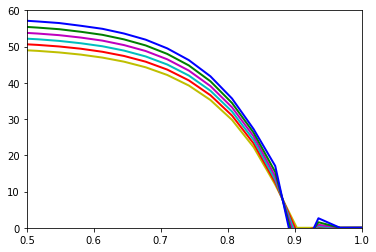

In [19]:
fig = plt.figure()
y=np.linspace(0,1,2**5)
ax = plt.axes(xlim=(0.5, 1), ylim=(0, 60))
line, = ax.plot(y,  linit[0]*np.real(checkwave_out(linit[1:])), 'y', lw=2)
line, = ax.plot(y,  solution[10][0]*np.real(checkwave_out(solution[10][1:])), 'r', lw=2)
line2, = ax.plot(y,  solution[20][0]*np.real(checkwave_out(solution[20][1:])), 'c', lw=2)
line3, = ax.plot(y,  solution[30][0]*np.real(checkwave_out(solution[30][1:])), 'm', lw=2)
line4, = ax.plot(y,  solution[40][0]*np.real(checkwave_out(solution[40][1:])), 'g', lw=2)
#line5, = ax.plot(y,  solution[8][0]*np.real(checkwave(solution[8][1:])), 'k', lw=2)
line6, = ax.plot(y,  solution[50][0]*np.real(checkwave_out(solution[50][1:])), 'b', lw=2)
#line7, = ax.plot(y,  solution[6][0]*np.real(checkwave(solution[6][1:])), 'y', lw=2)
#line7, = ax.plot(y,  solution[10][0]*np.real(checkwave(solution[10][1:])), 'k', lw=2)

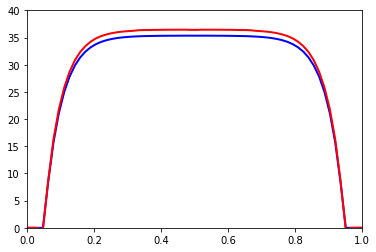

In [34]:
fig = plt.figure()
y=np.linspace(0,1,2**6)
ax = plt.axes(xlim=(0, 1), ylim=(0, 40))
line, = ax.plot(y,  linit[0]*np.real(checkwave(linit[1:])), 'b', lw=2)
line, = ax.plot(y,  best_params[0]*np.real(checkwave(best_params[1:])), 'r', lw=2)

In [2]:
for i in range(5,0,-1):
    print(i)

5
4
3
2
1
